# COVID-19 - Comparison of its evolution in different countries

<b>Check notebooks online</b>: we suggest NB Viewer to get a static view of notebooks and Google Colab for interactive ones --> 
<a href="https://colab.research.google.com/github/JeanRosselVallee/jupyter/blob/master/Covid/COVID-CompareDailyDeathsAsPercentage.ipynb" target="_blank"> 
    <button type="button"><b>Open in Colab</b></button>
</a>

### This comparison takes into account the population of a country and the starting date of deaths. 
Each curve represents the number of daily deaths as a percentage of the whole population in a country. The starting point is the date where the percentage is greater than 0.0001% (10 per million). 

## Get the input data

### Select the countries to process

In [ ]:
country_list = ['France', 'US', 'United Kingdom']

### Select the minimal count of deaths for the starting date 

In [ ]:
min_count = 0.0001 # percentage for 10 per million

### Choose Data tools

In [ ]:
import pandas as pnd

### Import Country Reference Data

In [ ]:
src_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19"
csv_ref_file = src_url + "/1a68338bddea934490f772051121adad47bf543e/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
ref_filter_column = 'Country_Region'
ref_data = pnd.read_csv(csv_ref_file)
ref_data = ref_data[ref_data[ref_filter_column].isin(country_list)]
ref_data = ref_data[ref_data['Province_State'].isnull()]
ref_data[['Country_Region','Population']].head()

,Country_Region,Population
58,France,65273512.0
62,Germany,83783945.0
81,Italy,60461828.0
117,Netherlands,17134873.0
153,Spain,46754783.0


### Import Daily Covid-19 Data

In [ ]:
csv_daily_file = src_url + "/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
filter_column = 'Country/Region'
drop_columns = ['Province/State', 'Lat', 'Long']
data_in = pnd.read_csv(csv_daily_file)
data_less_columns = data_in.drop(drop_columns, axis=1)    
data_less_rows = data_less_columns[data_less_columns[filter_column].isin(country_list)]
data_aggregated = data_less_rows.groupby(filter_column).sum() 
data = data_aggregated.reset_index()
data.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
0,France,0,0,0,0,0,0,0,0,0,...,10343,10887,12228,13215,13851,14412,14986,15748,17188,17941
1,Germany,0,0,0,0,0,0,0,0,0,...,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052
2,Italy,0,0,0,0,0,0,0,0,0,...,17127,17669,18279,18849,19468,19899,20465,21067,21645,22170
3,Netherlands,0,0,0,0,0,0,0,0,0,...,2108,2255,2403,2520,2653,2747,2833,2955,3145,3327
4,Spain,0,0,0,0,0,0,0,0,0,...,14045,14792,15447,16081,16606,17209,17756,18056,18708,19315


This original dataset organized as a table with timeseries as columns and 1 row per location (country, region, province). 
### Transform Input Data
It's easier to process this data with a different layout with 3 columns for each row of the new table: 1 column for the country, 1 for the date and 1 for the daily count as a percentage of the population.
Two sets of data are generated: 
- "data per country" takes into account the number of deaths taking place on the real date
- "data percentage" considers the number of deaths as a percentage of the population on a day count since the day where the number of deaths exceeded 10 per million. 

In [ ]:
data_per_country = pnd.DataFrame()
data_percentage = pnd.DataFrame()
new_columns = ['country', 'date', 'nb_cases']
date_list = pnd.DataFrame(data_aggregated.columns)
# first_date=data.columns[1]
for filter_value in country_list:
    ref_data_single_row = ref_data[ref_data[ref_filter_column] == filter_value]
    population = ref_data_single_row['Population'].values[0]
    country_data = data[data[filter_column] == filter_value]
    y_values = country_data.values[0,1:]
    bool_count_started = False
    quantum = 0
    prev = 0
    for date, value in zip(range(y_values.size), y_values):
        value = value - prev
        prev = prev + value
        rel_value = value / population * 100
        if bool_count_started:
            quantum = date - start_date
        elif rel_value >= min_count:
            start_date = date 
            bool_count_started = True
        data_per_country = data_per_country.append({
            'country':filter_value, 'date':date_list[0][date], 'nb_deaths':value}, ignore_index=True)
        data_percentage = data_percentage.append({
            'country':filter_value, 'day':quantum, 'deaths %':rel_value}, ignore_index=True)
display(data_per_country.tail(), data_percentage.tail())

,country,date,nb_deaths
683,United Kingdom,4/12/20,737.0
684,United Kingdom,4/13/20,718.0
685,United Kingdom,4/14/20,782.0
686,United Kingdom,4/15/20,765.0
687,United Kingdom,4/16/20,865.0


,country,day,deaths %
683,United Kingdom,19.0,0.001086
684,United Kingdom,20.0,0.001058
685,United Kingdom,21.0,0.001152
686,United Kingdom,22.0,0.001127
687,United Kingdom,23.0,0.001274


### Display the graph

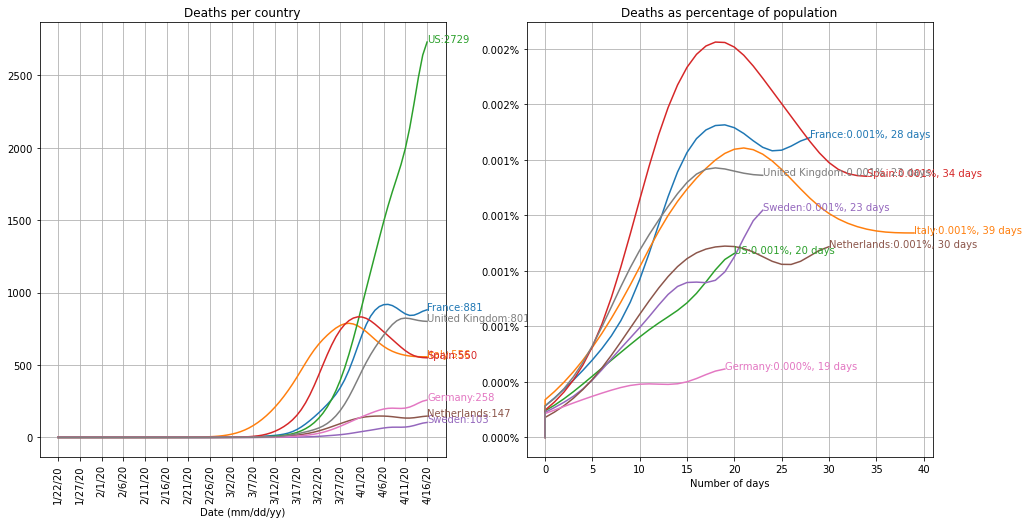

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.ndimage.filters import gaussian_filter1d
fig, (graph1, graph2) = plt.subplots(1, 2, figsize=(16,8))
for country in country_list:
    graph_per_country = graph1.plot(data_per_country[data_per_country['country'] == country]['date'], 
        gaussian_filter1d(data_per_country[data_per_country['country'] == country]['nb_deaths'], sigma=3), 
        label=country)
    last_x1, last_y1 = graph_per_country[0].get_data()[0][-1], graph_per_country[0].get_data()[1][-1]
    str_y1 = ':{:.0f}'.format(last_y1)
    graph1.annotate(xy=[last_x1, last_y1], s=country + str_y1, color=graph_per_country[0].get_color())
    graph_percentage = graph2.plot(data_percentage[data_percentage['country'] == country]['day'], 
        gaussian_filter1d(data_percentage[data_percentage['country'] == country]['deaths %'], sigma=3), 
        label=country)
    last_x2, last_y2 = graph_percentage[0].get_data()[0][-1], graph_percentage[0].get_data()[1][-1]
    str2 = ':{:.3f}%, {:.0f} days'.format(last_y2, last_x2) 
    graph2.annotate(xy=[last_x2, last_y2], s=country + str2, color=graph_percentage[0].get_color())
graph1.grid()
graph1.set_title('Deaths per country')
graph1.xaxis.set_major_locator(tck.MaxNLocator(20))
graph1.set_xlabel('Date (mm/dd/yy)')
graph1.tick_params('x', labelrotation=90)
graph2.grid()
graph2.set_title('Deaths as percentage of population')
graph2.set_xlabel('Number of days')
ticker = tck.StrMethodFormatter('{x:,.3f}%')
graph2.yaxis.set_major_formatter(ticker) 
plt.show()

Compare these two graphs: 
- "Deaths per country" is the classic graph that shows the number of deaths taking place on the real date
- "Deaths as a percentage of the population of the country" is a graph that shows the number of deaths as a percentage of the population on a day-count since the day where the number of deaths exceeded 10 per million. 